In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

widget_sales = pd.read_csv('data/widget_sales.csv')
widget_sales.columns = ['sales']
widget_sales.head()

sales
0  50.496714
1  50.805493
2  51.477758
3  53.542228
4  54.873108

In [2]:
print(widget_sales.shape)

(500, 1)


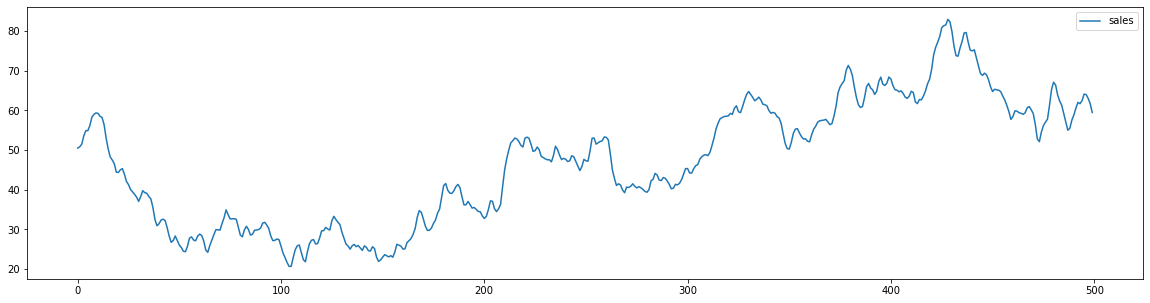

In [3]:
widget_sales.plot(figsize=(20,5));

In [4]:
adfuller(widget_sales['sales'], maxlag=40) # not stationary

(-1.5121662069359012,
 0.5274845352272624,
 3,
 496,
 {'1%': -3.4436029548776395,
  '5%': -2.867384756137026,
  '10%': -2.5698830308597813},
 1292.383277219345)

In [5]:
widget_sales['sales_diff'] = widget_sales['sales'].diff()
widget_sales.dropna(inplace=True)
widget_sales.head()

sales  sales_diff
1  50.805493    0.308778
2  51.477758    0.672265
3  53.542228    2.064470
4  54.873108    1.330880
5  54.885142    0.012034

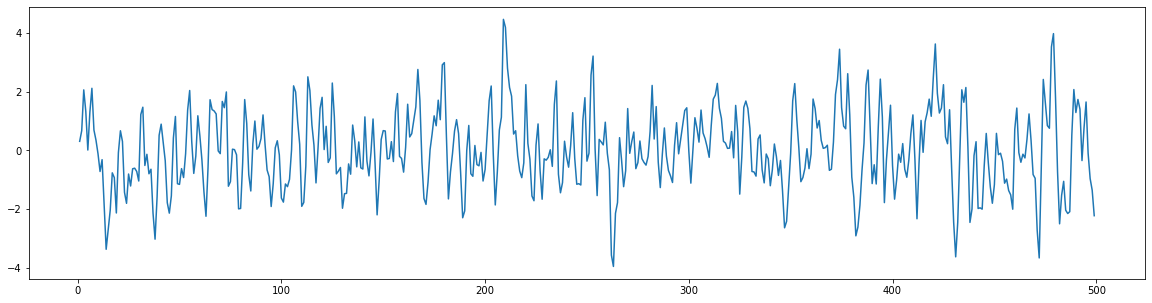

In [6]:
widget_sales['sales_diff'].plot(figsize=(20,5));

In [7]:
adfuller(widget_sales['sales_diff'], maxlag=40)

(-10.576657780341952,
 7.076922818587599e-19,
 2,
 496,
 {'1%': -3.4436029548776395,
  '5%': -2.867384756137026,
  '10%': -2.5698830308597813},
 1290.6849176727872)

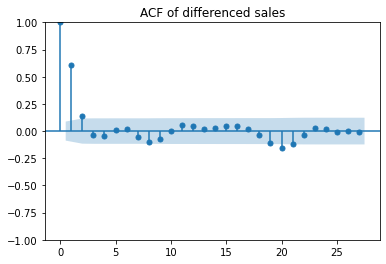

In [8]:
plot_acf(widget_sales['sales_diff'], title='ACF of differenced sales');

In [9]:
plot_pacf(widget_sales['sales_diff'], title='PACF of differenced sales');

/Users/Michael_Enudi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


In [11]:
forecast_horizon = int(0.1 * widget_sales.shape[0])

train = widget_sales[:-forecast_horizon]
test = widget_sales[-forecast_horizon:]

train_idx = widget_sales.index <= train.index[-1]
test_idx = widget_sales.index > train.index[-1]

print(train.shape)
print(test.shape)
print(train_idx.sum())
print(test_idx.sum())

(450, 2)
(49, 2)
450
49


In [12]:
q = 2
arima = ARIMA(train['sales_diff'], order=(0, 0, q))
fit = arima.fit()

in_sample_data = fit.get_prediction(start=train.index[0]-1, end=train.index[-1]-1).predicted_mean # or just fit.fittedvalues
out_sample_data = fit.forecast(steps=forecast_horizon)

/Users/Michael_Enudi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/Michael_Enudi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/Michael_Enudi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/Michael_Enudi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [13]:
from sklearn.metrics import mean_squared_error

train_mse_mean = mean_squared_error(train['sales_diff'], in_sample_data)
test_mse_mean = mean_squared_error(test['sales_diff'], out_sample_data)

print(f'train mean_squared_error is {train_mse_mean}')
print(f'test mean_squared_error is {test_mse_mean}')

print(f'test fit.sse is {fit.sse}')
print(f'test fit.sse/len(train) is {fit.sse/len(train)}')

train mean_squared_error is 0.9405469785239964
test mean_squared_error is 2.586726356739956
test fit.sse is 423.2461403357984
test fit.sse/len(train) is 0.9405469785239964


In [14]:
fig, ax = plt.subplots(figsize=(20,6))

ax.plot(widget_sales.index, widget_sales['sales_diff'], label='original')
ax.plot(train.index, in_sample_data, label='fittedvalue')
ax.plot(test.index, out_sample_data, label='out_of_sample')
ax.axvspan(450, 500, color='#808080', alpha=0.2)

ax.legend();

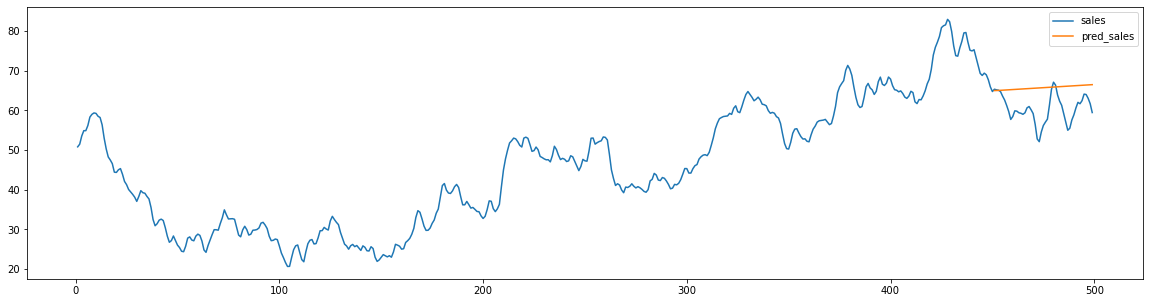

In [15]:
widget_sales['pred_sales'] = np.nan
widget_sales['pred_sales'][450:] = widget_sales['sales'].iloc[450] + out_sample_data.cumsum()

widget_sales[['sales', 'pred_sales']].plot(figsize=(20,5));

## Recursively solve MA(q) problem

In [ ]:
out_sample_data = []
train_idx_begin = len(train)
for i in range(train_idx_begin, len(widget_sales), q):
    arima = ARIMA(widget_sales.loc[:i+1, 'sales_diff'], order=(0, 0, q))
    fit = arima.fit()

    predictions = fit.get_prediction(0, i + q - 1)
    out_sample_data.extend(predictions.predicted_mean.iloc[-q:])


/Users/Michael_Enudi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/Michael_Enudi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/Michael_Enudi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/Michael_Enudi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/Michael_Enudi/opt/anaconda3/lib/python3.8/site-packages/stats

In [ ]:
out_sample_data = np.array(out_sample_data)
mse_mean = mean_squared_error(widget_sales.loc[train_idx_begin:, 'sales_diff'], out_sample_data)
print(f'mean_squared_error is {mse_mean}')

mean_squared_error is 0.6169168430876013


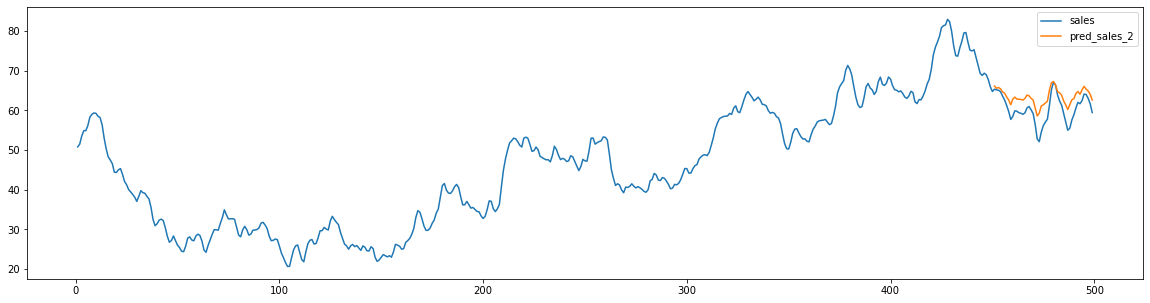

In [22]:
widget_sales['pred_sales_2'] = np.nan
widget_sales['pred_sales_2'][train_idx_begin:] = widget_sales['sales'].iloc[train_idx_begin] + out_sample_data[1:].cumsum()

widget_sales[['sales', 'pred_sales_2']].plot(figsize=(20,5));

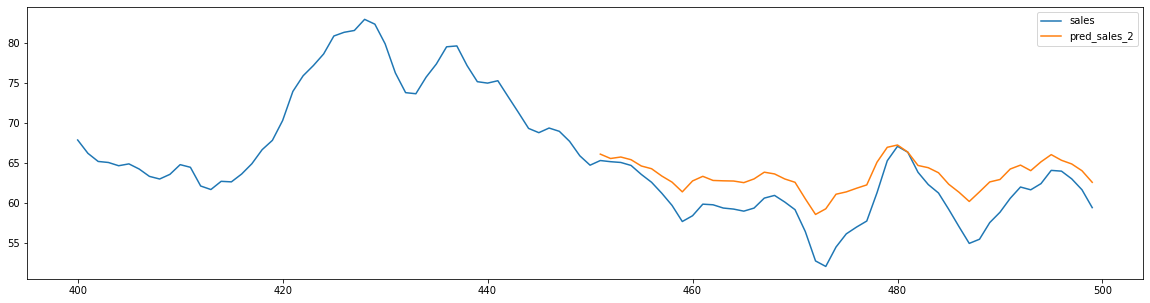

In [23]:
widget_sales[['sales', 'pred_sales_2']].iloc[-100:].plot(figsize=(20,5));